In [21]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [22]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
np.random.seed(91828)


In [23]:
def class_to_int(label , cl):
    temp = []
    for i in range(len(label)):
        #print(label[i])
        for j in range(len(cl)):
            if(label[i]==cl[j]):
                temp.append(j) 
    return temp
classes = ['BH' ,'NS' ]
ns_n = 0 
bh_n = 0


In [24]:

def get_xy(data):
    y = data['class']
    s = data['significance']
    info = data[['src_n' , 'src_id']]
    x = data.drop(columns=[ 'class' ,'src_n' ,'src_id' , 'significance'])
    #display(x)
    y_train_int = class_to_int(y, classes)
    one_hot_y_train =  to_categorical(y_train_int)
    global ns_n 
    global bh_n
    ns_n = float(y.value_counts()['NS']) 
    bh_n =  float(y.value_counts()['BH'])    
    print(ns_n , bh_n)
    return x , one_hot_y_train

In [25]:
def fit_model(model , x_train , one_hot_y_train , verbose=0 , validation=0.2):
    global ns_n 
    global bh_n 
    class_weight = {0: (ns_n/bh_n),
                    1: 1}
    history = model.fit(x_train, one_hot_y_train, batch_size=64, epochs=120, validation_split=validation, class_weight=class_weight, verbose=verbose )
    return history

In [26]:
def res_score(model , x , y ):
    y_prob = model.predict(x)
    y_pred = np.zeros_like(y_prob)
    y_pred[np.arange(len(y_prob)), y_prob.argmax(1)] = 1
    cf = np.matrix(np.matmul(y.T , y_pred))
    total = cf.sum()
    row_sum = cf.sum(axis=0)
    acc = np.trace(cf) / total 
    col_sum = cf.sum(axis=1) 
    #print(cf)
    return cf , acc


#_ , score = res_score(model , x , one_hot_y_train)
#print(score)

In [27]:
from tqdm import tqdm
def mc_validation(model_func , x , y , s=0.8 , model_name = '' , d_type = ''):
    from sklearn.model_selection import KFold
    kfold = KFold(8, True, 1)
    #k-fold cross-validation
    train_acc = []
    test_acc = []
    #s =  int(len(x)*s)
    x = np.array(x)
    y = np.array(y)
    index = np.arange(0,len(x))
    split_no = int(len(x)*s)
    print('split_no' , split_no)
    for i in tqdm(range(32)):
        np.random.shuffle(index)
        train_in ,test_in = index[:split_no] , index[split_no:]
        #print('-------------')
        #print(len(train_in ) , len(test_in))
        xtr  , ytr = x[train_in] , y[train_in]
        xtst , ytst = x[test_in] , y[test_in]
        model = model_func()
        fit_model(model , xtr , ytr , validation=0)
        _,train_acc_temp = res_score(model , xtr , ytr)
        _,test_acc_temp = res_score(model , xtst , ytst)
        train_acc.append(train_acc_temp)
        test_acc.append(test_acc_temp)
        print('-----------------------------------')
        print('training_acc :' , train_acc_temp)
        print('test_acc :' , test_acc_temp)
    acc_train =  pd.DataFrame()
    acc_test = pd.DataFrame()

    
    acc_test.insert(0 , 'acc_type' , ['Test_acc']*len(train_acc))
    acc_test.insert(1 , 'accuracy' , test_acc)
    acc_test = acc_test.reset_index(drop=True)
   
    acc_train.insert(0 , 'acc_type' , ['Train_acc']*len(train_acc))
    acc_train.insert(1 , 'accuracy' , train_acc)
    acc_train = acc_train.reset_index(drop=True)

    acc = pd.concat([acc_train , acc_test]).reset_index(drop=True)
    acc.insert(0 , 'model' , [model_name]*len(acc))
    acc.insert(1 , 'data_processing' , [d_type]*len(acc))
    return acc


## Load Data

In [28]:
data = pd.read_csv('/content/drive/MyDrive/thesis_data/train_norm' , index_col=0).reset_index(drop=True)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
display(data.describe())
x_norm , y_norm = get_xy(data)

data = pd.read_csv('/content/drive/MyDrive/thesis_data/train_std' , index_col=0).reset_index(drop=True)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
display(data.describe())
x_std , y_std = get_xy(data) 

data = pd.read_csv('/content/drive/MyDrive/thesis_data/train_og' , index_col=0).reset_index(drop=True)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
display(data.describe())
x_og , y_og = get_xy(data)

,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,flux_aper_lolim_b,flux_aper_s,flux_aper_u,flux_aper_m,flux_aper_h,flux_aper_b,photflux_aper_hilim_s,photflux_aper_hilim_u,photflux_aper_hilim_m,photflux_aper_hilim_h,photflux_aper_hilim_b,photflux_aper_lolim_s,photflux_aper_lolim_u,photflux_aper_lolim_m,photflux_aper_lolim_h,photflux_aper_lolim_b,photflux_aper_s,photflux_aper_u,photflux_aper_m,photflux_aper_h,photflux_aper_b,flux_aper_hilim,flux_aper_lolim,flux_aper,photflux_aper_hilim,photflux_aper_lolim,photflux_aper,var_index,var_prob,ks_prob,...,hard_hs_hilim,hard_hs_lolim,hard_ms_hilim,hard_ms_lolim,flux_powlaw,flux_powlaw_hilim,flux_powlaw_lolim,powlaw_gamma,powlaw_gamma_hilim,powlaw_gamma_lolim,powlaw_nh,powlaw_nh_hilim,powlaw_nh_lolim,powlaw_ampl,powlaw_ampl_hilim,powlaw_ampl_lolim,powlaw_stat,flux_bb,flux_bb_hilim,flux_bb_lolim,bb_kt,bb_kt_hilim,bb_kt_lolim,bb_nh_hilim,bb_nh_lolim,bb_nh,bb_ampl,bb_ampl_lolim,bb_ampl_hilim,bb_stat,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.680500,0.405772,0.299390,0.412578,0.475729,0.497027,0.330700,0.073759,0.336558,0.396229,0.464286,0.278792,0.071347,0.298304,0.380401,0.443977,0.408158,0.358300,0.442278,0.452250,0.450823,0.343939,0.118870,0.356446,0.386358,0.474684,0.302829,0.103972,0.317784,0.381053,0.437388,0.494853,0.557515,0.520756,0.518434,0.556244,0.511243,0.053737,0.291850,0.349028,...,0.615579,0.396395,0.542737,0.320966,0.022906,0.023155,0.021840,0.048914,0.047728,0.063226,0.011244,0.014108,0.009211,0.002678,0.004596,0.002699,0.017178,0.023085,0.022398,0.021860,0.021469,0.002871,0.018983,0.011187,0.007029,0.008754,0.012551,0.010463,0.014765,0.022803,0.023443,0.022373,0.023921,0.010732,0.014849,0.006533,0.011490,0.012215,0.010280,0.012353
std,109.946267,0.221633,0.242112,0.202805,0.201697,0.194583,0.293861,0.183519,0.276541,0.268479,0.237701,0.265877,0.170002,0.251260,0.248559,0.222200,0.217087,0.280596,0.214517,0.197441,0.189303,0.298904,0.227551,0.294613,0.259726,0.231129,0.270977,0.210604,0.272386,0.240293,0.213152,0.181428,0.196856,0.182442,0.196519,0.190836,0.180478,0.119511,0.243169,0.308933,...,0.338917,0.331166,0.290747,0.287450,0.104713,0.105950,0.098662,0.151769,0.148985,0.181022,0.068075,0.086694,0.059822,0.046889,0.048036,0.046865,0.064963,0.108088,0.106689,0.103259,0.089343,0.046693,0.076489,0.082876,0.058438,0.066126,0.069716,0.063088,0.078496,0.079581,0.108967,0.105301,0.110320,0.085034,0.077365,0.052629,0.075177,0.080658,0.068562,0.059748
min,2.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

302.0 158.0


,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,flux_aper_lolim_b,flux_aper_s,flux_aper_u,flux_aper_m,flux_aper_h,flux_aper_b,photflux_aper_hilim_s,photflux_aper_hilim_u,photflux_aper_hilim_m,photflux_aper_hilim_h,photflux_aper_hilim_b,photflux_aper_lolim_s,photflux_aper_lolim_u,photflux_aper_lolim_m,photflux_aper_lolim_h,photflux_aper_lolim_b,photflux_aper_s,photflux_aper_u,photflux_aper_m,photflux_aper_h,photflux_aper_b,flux_aper_hilim,flux_aper_lolim,flux_aper,photflux_aper_hilim,photflux_aper_lolim,photflux_aper,var_index,var_prob,ks_prob,...,hard_hs_hilim,hard_hs_lolim,hard_ms_hilim,hard_ms_lolim,flux_powlaw,flux_powlaw_hilim,flux_powlaw_lolim,powlaw_gamma,powlaw_gamma_hilim,powlaw_gamma_lolim,powlaw_nh,powlaw_nh_hilim,powlaw_nh_lolim,powlaw_ampl,powlaw_ampl_hilim,powlaw_ampl_lolim,powlaw_stat,flux_bb,flux_bb_hilim,flux_bb_lolim,bb_kt,bb_kt_hilim,bb_kt_lolim,bb_nh_hilim,bb_nh_lolim,bb_nh,bb_ampl,bb_ampl_lolim,bb_ampl_hilim,bb_stat,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,...,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02,4.600000e+02
mean,70.680500,-1.931064e-14,-4.390932e-15,-6.386196e-16,1.666505e-14,7.306474e-15,7.069707e-15,2.503809e-16,-1.143349e-14,-8.084837e-15,6.364625e-15,-3.320291e-15,8.723698e-16,-3.911967e-15,7.966816e-15,1.577965e-14,1.522936e-15,5.082891e-16,-1.124946e-15,-9.635167e-15,1.338686e-15,-9.306565e-16,-5.642829e-16,3.609070e-15,-1.021888e-15,-2.432656e-15,-1.732431e-15,9.694842e-17,-2.221049e-15,-4.433652e-16,7.107690e-16,1.408499e-14,2.223342e-15,4.558853e-15,-3.501788e-15,5.235788e-15,-4.541672e-15,-6.323444e-17,5.111853e-16,4.968248e-16,...,-2.710392e-16,2.413528e-17,2.616265e-16,1.158494e-17,3.330669e-17,1.375711e-17,-3.765104e-17,-4.271945e-17,6.130362e-17,9.461031e-17,1.411914e-17,1.230899e-17,-5.068409e-18,8.990393e-18,-2.051499e-18,-4.525366e-18,-8.604228e-17,1.834282e-17,-3.692698e-17,-4.296080e-17,-1.954958e-17,4.102998e-18,2.220446e-17,1.689470e-18,3.016910e-18,3.740969e-18,-5.068409e-18,-1.632149e-17,2.715219e-17,-7.783629e-18,-2.896234e-18,-4.827057e-19,-1.568793e-17,9.654113e-18,7.723291e-18,-4.585704e-18,-7.602614e-18,-1.206764e-17,-1.206764e-17,1.906687e-17
std,109.946267,9.667681e-01,8.631906e-01,9.701425e-01,9.868415e-01,9.934426e-01,8.016867e-01,4.122313e-01,8.336601e-01,8.843840e-01,9.439637e-01,8.164966e-01,4.353648e-01,8.504772e-01,9.038769e-01,9.599837e-01,9.746236e-01,9.098828e-01,9.779709e-01,9.967267e-01,9.923454e-01,8.016867e-01,5.155533e-01,8.297308e-01,8.929645e-01,9.497162e-01,8.178296e-01,5.463286e-01,8.440488e-01,9.146591e-01,9.633818e-01,1.001089e+00,9.868415e-01,1.001089e+00,1.001089e+00,9.879448e-01,9.934426e-01,8.284169e-01,8.284169e-01,8.284169e-01,...,9.723856e-01,9.723856e-01,9.622504e-01,9.622504e-01,3.523961e-01,3.523961e-01,3.523961e-01,3.523961e-01,3.523961e-01,3.523961e-01

302.0 158.0


,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,flux_aper_lolim_b,flux_aper_s,flux_aper_u,flux_aper_m,flux_aper_h,flux_aper_b,photflux_aper_hilim_s,photflux_aper_hilim_u,photflux_aper_hilim_m,photflux_aper_hilim_h,photflux_aper_hilim_b,photflux_aper_lolim_s,photflux_aper_lolim_u,photflux_aper_lolim_m,photflux_aper_lolim_h,photflux_aper_lolim_b,photflux_aper_s,photflux_aper_u,photflux_aper_m,photflux_aper_h,photflux_aper_b,flux_aper_hilim,flux_aper_lolim,flux_aper,photflux_aper_hilim,photflux_aper_lolim,photflux_aper,var_index,var_prob,ks_prob,...,hard_hs_hilim,hard_hs_lolim,hard_ms_hilim,hard_ms_lolim,flux_powlaw,flux_powlaw_hilim,flux_powlaw_lolim,powlaw_gamma,powlaw_gamma_hilim,powlaw_gamma_lolim,powlaw_nh,powlaw_nh_hilim,powlaw_nh_lolim,powlaw_ampl,powlaw_ampl_hilim,powlaw_ampl_lolim,powlaw_stat,flux_bb,flux_bb_hilim,flux_bb_lolim,bb_kt,bb_kt_hilim,bb_kt_lolim,bb_nh_hilim,bb_nh_lolim,bb_nh,bb_ampl,bb_ampl_lolim,bb_ampl_hilim,bb_stat,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,4.600000e+02,4.600000e+02,4.600000e+02,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,4.600000e+02,4.600000e+02,4.600000e+02,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,4.600000e+02,4.600000e+02,4.600000e+02,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.680500,-13.665727,-10.585485,-13.672153,-13.524028,-13.598865,-9.545423,-2.479007,-10.270777,-11.095915,-12.498400,-9.697621,-2.679656,-10.491571,-11.340224,-12.737676,-5.572660,-4.193685,-5.703923,-5.698617,-5.180575,-3.907787,-1.557560,-4.249623,-4.805794,-5.002329,-3.866819,-1.596052,-4.204678,-4.796025,-4.958673,-13.980383,-14.150584,-14.269228,-5.348413,-5.919781,-5.654965,0.494384,0.305254,0.350833,...,0.304895,-0.151678,0.178714,-0.354552,4.148278e-14,4.365084e-14,3.820060e-14,0.395028,0.437861,0.356772,20.025880,25.727326,15.800296,0.000496,0.000138,0.000366,0.134785,3.794652e-14,4.150991e-14,3.340407e-14,0.079066,0.262875,0.070618,13.858500,7.493357,10.049044,0.000339,0.000265,0.000468,0.218237,3.976932e-14,3.684994e-14,4.187235e-14,1.109605,0.566298,0.565308,16.913367,20.985130,14.195144,0.158613
std,109.946267,3.758502,6.281784,3.562725,2.445021,1.872480,7.192002,5.508112,6.885564,5.952367,4.500401,6.919272,5.567085,6.557210,5.450454,3.846454,1.527561,2.091813,1.470996,0.945157,1.024494,3.036423,2.636122,2.986940,2.572452,1.899964,2.813596,2.490937,2.770819,2.243113,1.602113,0.752165,2.624883,0.860268,0.783203,1.410366,1.070965,1.099499,0.246826,0.309041,...,0.595774,0.633504,0.482503,0.493585,1.887868e-13,1.974831e-13,1.725618e-13,1.178431,1.293248,1.085263,121.242172,157.649872,102.115153,0.008679,0.001434,0.006350,0.409767,1.760791e-13,1.958238e-13,1.572686e-13,0.274417,3.883612,0.236322,102.602843,62.295068,75.913177,0.001884,0.001597,0.002486,0.693169,1.828352e-13,1.716889e-13,1.908868e-13,8.512305,2.798337,4.297048,110.659935,138.121021,94.621092,0.603954
min,2.110000,-16.403623,-16.286762,-16.438660,-16.050805,-16.001523,-17.513428,-16.808549,-17.283162,-16.795609,-16.656394,-16.151749,-15.850473,-16.201833,-15.840433,-15.890759,-7.620694,-6.633017,-7.858550,-7.593119,-7.207678,-8.964170,-7.720789,-8.698102,-8.377682,-8.40

302.0 158.0


# Convolution Neural Network

In [29]:
def gen_model_cnn():

    visible = layers.Input(shape=(92,1))
    x = layers.BatchNormalization(axis=-1)(visible)
    #x = tf.keras.layers.LeakyReLU(alpha=0.3)(visible)
    x = layers.Conv1D(32, kernel_size=3, activation='relu' , kernel_regularizer= 'l2', kernel_initializer='he_normal')(x)
    x = layers.MaxPool1D(pool_size=(2))(x)

    #x = layers.Conv1D(32, kernel_size=4, activation='relu' ,   kernel_regularizer= 'l2', kernel_initializer='he_normal')(x)
    #x = layers.MaxPool1D(pool_size=(2))(x)
    x = layers.Conv1D(16, kernel_size=3, activation='relu' , kernel_regularizer= 'l2', kernel_initializer='he_normal')(x)
    x = layers.MaxPooling1D(pool_size=(2))(x)
    #x = layers.Conv1D(32, kernel_size=4, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=(2))(x)
    x = layers.Flatten()(x)
    #x = layers.BatchNormalization(axis=-1)(x)
    x = layers.Dense(16, activation='relu' ,  kernel_regularizer= 'l2',kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(16, activation='relu')(x)
    output = layers.Dense(2, activation='softmax' , kernel_regularizer= 'l2' , kernel_initializer='he_normal')(x)
    model_cnn = keras.Model(inputs=visible, outputs=output)
    # summarize layers
    #print(model_cnn.summary())
    model_cnn.compile(
            loss = "categorical_crossentropy",
            optimizer = keras.optimizers.Adam(learning_rate=0.0005),
            metrics = ["accuracy"], 
        )
    
    return model_cnn


# Fully Connected network

In [30]:

def gen_model_fc():

    inputs =  keras.Input(shape=(92,))
    dense =  layers.Dense(32, activation='relu')
    x = dense(inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(2 , activation='softmax')(x)
    model = keras.Model(inputs=inputs , outputs=outputs , name='trial_model')
    model.compile(
        loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(learning_rate=0.0005),
        metrics = ["accuracy"],
    )
    return model


In [31]:
acc_norm_cnn = mc_validation(gen_model_cnn , x_norm , y_norm , model_name = 'CNN' , d_type='Normalized')
acc_std_cnn = mc_validation(gen_model_cnn , x_std , y_std ,  model_name = 'CNN' , d_type = 'Standardized')
acc_og_cnn = mc_validation(gen_model_cnn , x_og , y_og ,  model_name = 'CNN' , d_type = 'None')

acc_norm_fc = mc_validation(gen_model_fc , x_norm , y_norm , model_name = 'FC' , d_type='Normalized')
acc_std_fc = mc_validation(gen_model_fc , x_std , y_std ,  model_name = 'FC'  , d_type = 'Standardized')
acc_og_fc = mc_validation(gen_model_fc , x_og , y_og ,  model_name = 'FC' , d_type = 'None')


split_no 368


  3%|▎         | 1/32 [00:06<03:09,  6.11s/it]

-----------------------------------
training_acc : 0.9701087
test_acc : 0.8913044


  6%|▋         | 2/32 [00:12<03:01,  6.06s/it]

-----------------------------------
training_acc : 0.9320652
test_acc : 0.8695652


  9%|▉         | 3/32 [00:18<02:55,  6.06s/it]

-----------------------------------
training_acc : 0.97282606
test_acc : 0.9130435


 12%|█▎        | 4/32 [00:24<02:52,  6.16s/it]

-----------------------------------
training_acc : 0.9673913
test_acc : 0.8369565


 16%|█▌        | 5/32 [00:30<02:44,  6.11s/it]

-----------------------------------
training_acc : 0.98097825
test_acc : 0.8369565


 19%|█▉        | 6/32 [00:36<02:38,  6.10s/it]

-----------------------------------
training_acc : 0.96467394
test_acc : 0.8695652


 22%|██▏       | 7/32 [00:42<02:32,  6.08s/it]

-----------------------------------
training_acc : 0.9320652
test_acc : 0.8586956


 25%|██▌       | 8/32 [00:48<02:25,  6.08s/it]

-----------------------------------
training_acc : 0.96467394
test_acc : 0.8152174


 28%|██▊       | 9/32 [00:55<02:22,  6.19s/it]

-----------------------------------
training_acc : 0.9211956
test_acc : 0.9130435


 31%|███▏      | 10/32 [01:01<02:16,  6.18s/it]

-----------------------------------
training_acc : 0.9592391
test_acc : 0.8369565


 34%|███▍      | 11/32 [01:07<02:09,  6.18s/it]

-----------------------------------
training_acc : 0.9782609
test_acc : 0.84782606


 38%|███▊      | 12/32 [01:13<02:03,  6.15s/it]

-----------------------------------
training_acc : 0.92663044
test_acc : 0.8586956


 41%|████      | 13/32 [01:19<01:56,  6.14s/it]

-----------------------------------
training_acc : 0.92391306
test_acc : 0.8695652


 44%|████▍     | 14/32 [01:25<01:50,  6.14s/it]

-----------------------------------
training_acc : 0.98097825
test_acc : 0.8804348


 47%|████▋     | 15/32 [01:32<01:47,  6.30s/it]

-----------------------------------
training_acc : 0.9402174
test_acc : 0.8586956


 50%|█████     | 16/32 [01:39<01:41,  6.36s/it]

-----------------------------------
training_acc : 0.9673913
test_acc : 0.82608694


 53%|█████▎    | 17/32 [01:45<01:35,  6.38s/it]

-----------------------------------
training_acc : 0.94836956
test_acc : 0.8695652


 56%|█████▋    | 18/32 [01:51<01:29,  6.38s/it]

-----------------------------------
training_acc : 0.9538044
test_acc : 0.8695652


 59%|█████▉    | 19/32 [01:58<01:23,  6.39s/it]

-----------------------------------
training_acc : 0.98641306
test_acc : 0.8913044


 62%|██████▎   | 20/32 [02:04<01:16,  6.38s/it]

-----------------------------------
training_acc : 0.96467394
test_acc : 0.8804348


 66%|██████▌   | 21/32 [02:11<01:11,  6.47s/it]

-----------------------------------
training_acc : 0.95652175
test_acc : 0.84782606


 69%|██████▉   | 22/32 [02:17<01:04,  6.47s/it]

-----------------------------------
training_acc : 0.9592391
test_acc : 0.84782606


 72%|███████▏  | 23/32 [02:24<00:58,  6.45s/it]

-----------------------------------
training_acc : 0.9673913
test_acc : 0.90217394


 75%|███████▌  | 24/32 [02:30<00:51,  6.43s/it]

-----------------------------------
training_acc : 0.9592391
test_acc : 0.8586956


 78%|███████▊  | 25/32 [02:37<00:45,  6.46s/it]

-----------------------------------
training_acc : 0.9945652
test_acc : 0.8369565


 81%|████████▏ | 26/32 [02:43<00:38,  6.47s/it]

-----------------------------------
training_acc : 0.96467394
test_acc : 0.8586956


 84%|████████▍ | 27/32 [02:50<00:32,  6.56s/it]

-----------------------------------
training_acc : 0.92663044
test_acc : 0.8695652


 88%|████████▊ | 28/32 [02:56<00:26,  6.53s/it]

-----------------------------------
training_acc : 0.9347826
test_acc : 0.84782606


 91%|█████████ | 29/32 [03:03<00:19,  6.48s/it]

-----------------------------------
training_acc : 0.97282606
test_acc : 0.8913044


 94%|█████████▍| 30/32 [03:09<00:12,  6.45s/it]

-----------------------------------
training_acc : 0.9347826
test_acc : 0.8586956


 97%|█████████▋| 31/32 [03:15<00:06,  6.43s/it]

-----------------------------------
training_acc : 0.9755435
test_acc : 0.90217394


100%|██████████| 32/32 [03:22<00:00,  6.32s/it]


-----------------------------------
training_acc : 0.97282606
test_acc : 0.8695652
split_no 368


  3%|▎         | 1/32 [00:06<03:26,  6.66s/it]

-----------------------------------
training_acc : 0.9782609
test_acc : 0.82608694


  6%|▋         | 2/32 [00:13<03:16,  6.55s/it]

-----------------------------------
training_acc : 0.9755435
test_acc : 0.8804348


  9%|▉         | 3/32 [00:19<03:08,  6.52s/it]

-----------------------------------
training_acc : 0.98097825
test_acc : 0.7826087


 12%|█▎        | 4/32 [00:26<03:02,  6.52s/it]

-----------------------------------
training_acc : 0.9782609
test_acc : 0.8804348


 16%|█▌        | 5/32 [00:32<02:57,  6.56s/it]

-----------------------------------
training_acc : 0.96467394
test_acc : 0.8152174


 19%|█▉        | 6/32 [00:39<02:52,  6.64s/it]

-----------------------------------
training_acc : 0.98641306
test_acc : 0.8369565


 22%|██▏       | 7/32 [00:46<02:44,  6.58s/it]

-----------------------------------
training_acc : 0.98097825
test_acc : 0.8369565


 25%|██▌       | 8/32 [00:52<02:37,  6.58s/it]

-----------------------------------
training_acc : 0.9782609
test_acc : 0.8369565


 28%|██▊       | 9/32 [00:59<02:31,  6.57s/it]

-----------------------------------
training_acc : 0.9918478
test_acc : 0.8586956


 31%|███▏      | 10/32 [01:05<02:24,  6.56s/it]

-----------------------------------
training_acc : 0.9836956
test_acc : 0.7826087


 34%|███▍      | 11/32 [01:12<02:16,  6.52s/it]

-----------------------------------
training_acc : 0.9673913
test_acc : 0.82608694


 38%|███▊      | 12/32 [01:19<02:13,  6.68s/it]

-----------------------------------
training_acc : 0.9701087
test_acc : 0.8043478


 41%|████      | 13/32 [01:25<02:07,  6.71s/it]

-----------------------------------
training_acc : 0.96467394
test_acc : 0.90217394


 44%|████▍     | 14/32 [01:32<02:00,  6.69s/it]

-----------------------------------
training_acc : 0.9701087
test_acc : 0.8152174


 47%|████▋     | 15/32 [01:39<01:53,  6.70s/it]

-----------------------------------
training_acc : 0.9782609
test_acc : 0.84782606


 50%|█████     | 16/32 [01:46<01:47,  6.70s/it]

-----------------------------------
training_acc : 0.98913044
test_acc : 0.84782606


 53%|█████▎    | 17/32 [01:52<01:40,  6.71s/it]

-----------------------------------
training_acc : 0.9456522
test_acc : 0.8695652


 56%|█████▋    | 18/32 [01:59<01:35,  6.80s/it]

-----------------------------------
training_acc : 0.97282606
test_acc : 0.8804348


 59%|█████▉    | 19/32 [02:06<01:27,  6.75s/it]

-----------------------------------
training_acc : 0.9592391
test_acc : 0.8804348


 62%|██████▎   | 20/32 [02:13<01:20,  6.73s/it]

-----------------------------------
training_acc : 0.9918478
test_acc : 0.7173913


 66%|██████▌   | 21/32 [02:19<01:13,  6.69s/it]

-----------------------------------
training_acc : 0.95108694
test_acc : 0.8369565


 69%|██████▉   | 22/32 [02:26<01:06,  6.70s/it]

-----------------------------------
training_acc : 0.9755435
test_acc : 0.8152174


 72%|███████▏  | 23/32 [02:32<00:59,  6.65s/it]

-----------------------------------
training_acc : 0.9755435
test_acc : 0.8152174


 75%|███████▌  | 24/32 [02:39<00:53,  6.70s/it]

-----------------------------------
training_acc : 0.98913044
test_acc : 0.8369565


 78%|███████▊  | 25/32 [02:46<00:46,  6.68s/it]

-----------------------------------
training_acc : 0.9945652
test_acc : 0.82608694


 81%|████████▏ | 26/32 [02:52<00:39,  6.64s/it]

-----------------------------------
training_acc : 0.95652175
test_acc : 0.8695652


 84%|████████▍ | 27/32 [02:59<00:33,  6.62s/it]

-----------------------------------
training_acc : 0.97282606
test_acc : 0.8586956


 88%|████████▊ | 28/32 [03:06<00:26,  6.61s/it]

-----------------------------------
training_acc : 0.98913044
test_acc : 0.84782606


 91%|█████████ | 29/32 [03:12<00:19,  6.61s/it]

-----------------------------------
training_acc : 0.98913044
test_acc : 0.9130435


 94%|█████████▍| 30/32 [03:19<00:13,  6.71s/it]

-----------------------------------
training_acc : 0.97282606
test_acc : 0.82608694


 97%|█████████▋| 31/32 [03:26<00:06,  6.72s/it]

-----------------------------------
training_acc : 0.98641306
test_acc : 0.8369565


100%|██████████| 32/32 [03:32<00:00,  6.65s/it]


-----------------------------------
training_acc : 0.97282606
test_acc : 0.8369565
split_no 368


  3%|▎         | 1/32 [00:06<03:17,  6.37s/it]

-----------------------------------
training_acc : 0.80163044
test_acc : 0.7826087


  6%|▋         | 2/32 [00:12<03:12,  6.43s/it]

-----------------------------------
training_acc : 0.8206522
test_acc : 0.75


  9%|▉         | 3/32 [00:19<03:07,  6.45s/it]

-----------------------------------
training_acc : 0.7717391
test_acc : 0.7282609


 12%|█▎        | 4/32 [00:26<03:04,  6.58s/it]

-----------------------------------
training_acc : 0.7907609
test_acc : 0.7173913


 16%|█▌        | 5/32 [00:32<02:55,  6.51s/it]

-----------------------------------
training_acc : 0.8125
test_acc : 0.7826087


 19%|█▉        | 6/32 [00:38<02:49,  6.51s/it]

-----------------------------------
training_acc : 0.7581522
test_acc : 0.7282609


 22%|██▏       | 7/32 [00:45<02:41,  6.47s/it]

-----------------------------------
training_acc : 0.7554348
test_acc : 0.7826087


 25%|██▌       | 8/32 [00:51<02:34,  6.45s/it]

-----------------------------------
training_acc : 0.8097826
test_acc : 0.7282609


 28%|██▊       | 9/32 [00:58<02:28,  6.46s/it]

-----------------------------------
training_acc : 0.73641306
test_acc : 0.6847826


 31%|███▏      | 10/32 [01:04<02:23,  6.54s/it]

-----------------------------------
training_acc : 0.8043478
test_acc : 0.76086956


 34%|███▍      | 11/32 [01:11<02:17,  6.55s/it]

-----------------------------------
training_acc : 0.7826087
test_acc : 0.73913044


 38%|███▊      | 12/32 [01:18<02:10,  6.53s/it]

-----------------------------------
training_acc : 0.7663044
test_acc : 0.7282609


 41%|████      | 13/32 [01:24<02:03,  6.48s/it]

-----------------------------------
training_acc : 0.78532606
test_acc : 0.6847826


 44%|████▍     | 14/32 [01:30<01:55,  6.42s/it]

-----------------------------------
training_acc : 0.7554348
test_acc : 0.7717391


 47%|████▋     | 15/32 [01:37<01:48,  6.39s/it]

-----------------------------------
training_acc : 0.7527174
test_acc : 0.7173913


 50%|█████     | 16/32 [01:43<01:43,  6.47s/it]

-----------------------------------
training_acc : 0.7255435
test_acc : 0.6086956


 53%|█████▎    | 17/32 [01:50<01:36,  6.46s/it]

-----------------------------------
training_acc : 0.76086956
test_acc : 0.70652175


 56%|█████▋    | 18/32 [01:56<01:29,  6.41s/it]

-----------------------------------
training_acc : 0.79347825
test_acc : 0.7717391


 59%|█████▉    | 19/32 [02:02<01:22,  6.38s/it]

-----------------------------------
training_acc : 0.7663044
test_acc : 0.75


 62%|██████▎   | 20/32 [02:09<01:16,  6.38s/it]

-----------------------------------
training_acc : 0.7581522
test_acc : 0.73913044


 66%|██████▌   | 21/32 [02:15<01:09,  6.35s/it]

-----------------------------------
training_acc : 0.7907609
test_acc : 0.7173913


 69%|██████▉   | 22/32 [02:21<01:04,  6.43s/it]

-----------------------------------
training_acc : 0.76902175
test_acc : 0.82608694


 72%|███████▏  | 23/32 [02:28<00:57,  6.40s/it]

-----------------------------------
training_acc : 0.8043478
test_acc : 0.75


 75%|███████▌  | 24/32 [02:34<00:50,  6.36s/it]

-----------------------------------
training_acc : 0.7663044
test_acc : 0.7282609


 78%|███████▊  | 25/32 [02:40<00:44,  6.37s/it]

-----------------------------------
training_acc : 0.79891306
test_acc : 0.7826087


 81%|████████▏ | 26/32 [02:47<00:38,  6.34s/it]

-----------------------------------
training_acc : 0.7880435
test_acc : 0.65217394


 84%|████████▍ | 27/32 [02:53<00:32,  6.44s/it]

-----------------------------------
training_acc : 0.79891306
test_acc : 0.6195652


 88%|████████▊ | 28/32 [03:00<00:25,  6.43s/it]

-----------------------------------
training_acc : 0.7554348
test_acc : 0.73913044


 91%|█████████ | 29/32 [03:06<00:19,  6.43s/it]

-----------------------------------
training_acc : 0.7554348
test_acc : 0.6956522


 94%|█████████▍| 30/32 [03:13<00:12,  6.42s/it]

-----------------------------------
training_acc : 0.8423913
test_acc : 0.6630435


 97%|█████████▋| 31/32 [03:19<00:06,  6.42s/it]

-----------------------------------
training_acc : 0.75
test_acc : 0.7173913


100%|██████████| 32/32 [03:26<00:00,  6.44s/it]


-----------------------------------
training_acc : 0.79891306
test_acc : 0.6847826
split_no 368


  3%|▎         | 1/32 [00:01<00:59,  1.92s/it]

-----------------------------------
training_acc : 0.9673913
test_acc : 0.8369565


  6%|▋         | 2/32 [00:03<00:59,  1.97s/it]

-----------------------------------
training_acc : 0.97282606
test_acc : 0.8804348


  9%|▉         | 3/32 [00:05<00:56,  1.94s/it]

-----------------------------------
training_acc : 0.94836956
test_acc : 0.8152174


 12%|█▎        | 4/32 [00:07<00:52,  1.86s/it]

-----------------------------------
training_acc : 0.9782609
test_acc : 0.84782606


 16%|█▌        | 5/32 [00:09<00:48,  1.81s/it]

-----------------------------------
training_acc : 0.98913044
test_acc : 0.8913044


 19%|█▉        | 6/32 [00:11<00:47,  1.84s/it]

-----------------------------------
training_acc : 0.9782609
test_acc : 0.8152174


 22%|██▏       | 7/32 [00:12<00:44,  1.80s/it]

-----------------------------------
training_acc : 0.98097825
test_acc : 0.84782606


 25%|██▌       | 8/32 [00:14<00:44,  1.84s/it]

-----------------------------------
training_acc : 0.98097825
test_acc : 0.8695652


 28%|██▊       | 9/32 [00:16<00:41,  1.79s/it]

-----------------------------------
training_acc : 0.98641306
test_acc : 0.8586956


 31%|███▏      | 10/32 [00:18<00:40,  1.82s/it]

-----------------------------------
training_acc : 0.9836956
test_acc : 0.79347825


 34%|███▍      | 11/32 [00:20<00:39,  1.88s/it]

-----------------------------------
training_acc : 0.98097825
test_acc : 0.8913044


 38%|███▊      | 12/32 [00:22<00:37,  1.89s/it]

-----------------------------------
training_acc : 0.9836956
test_acc : 0.8152174


 41%|████      | 13/32 [00:24<00:34,  1.83s/it]

-----------------------------------
training_acc : 0.9782609
test_acc : 0.8695652


 44%|████▍     | 14/32 [00:25<00:33,  1.86s/it]

-----------------------------------
training_acc : 0.9755435
test_acc : 0.8586956


 47%|████▋     | 15/32 [00:27<00:30,  1.81s/it]

-----------------------------------
training_acc : 0.9701087
test_acc : 0.8043478


 50%|█████     | 16/32 [00:29<00:28,  1.78s/it]

-----------------------------------
training_acc : 0.9701087
test_acc : 0.8695652


 53%|█████▎    | 17/32 [00:31<00:27,  1.82s/it]

-----------------------------------
training_acc : 0.98097825
test_acc : 0.84782606


 56%|█████▋    | 18/32 [00:32<00:24,  1.78s/it]

-----------------------------------
training_acc : 0.98097825
test_acc : 0.82608694


 59%|█████▉    | 19/32 [00:34<00:23,  1.82s/it]

-----------------------------------
training_acc : 0.9836956
test_acc : 0.84782606


 62%|██████▎   | 20/32 [00:37<00:23,  1.94s/it]

-----------------------------------
training_acc : 0.9592391
test_acc : 0.9130435


 66%|██████▌   | 21/32 [00:38<00:20,  1.87s/it]

-----------------------------------
training_acc : 0.98913044
test_acc : 0.8369565


 69%|██████▉   | 22/32 [00:40<00:18,  1.89s/it]

-----------------------------------
training_acc : 0.9836956
test_acc : 0.8369565


 72%|███████▏  | 23/32 [00:42<00:17,  1.89s/it]

-----------------------------------
training_acc : 0.9701087
test_acc : 0.8586956


 75%|███████▌  | 24/32 [00:44<00:14,  1.83s/it]

-----------------------------------
training_acc : 0.98097825
test_acc : 0.8369565


 78%|███████▊  | 25/32 [00:46<00:12,  1.80s/it]

-----------------------------------
training_acc : 0.9782609
test_acc : 0.8913044


 81%|████████▏ | 26/32 [00:47<00:10,  1.83s/it]

-----------------------------------
training_acc : 0.98097825
test_acc : 0.8695652


 84%|████████▍ | 27/32 [00:49<00:09,  1.86s/it]

-----------------------------------
training_acc : 0.96467394
test_acc : 0.84782606


 88%|████████▊ | 28/32 [00:51<00:07,  1.87s/it]

-----------------------------------
training_acc : 0.98097825
test_acc : 0.84782606


 91%|█████████ | 29/32 [00:53<00:05,  1.91s/it]

-----------------------------------
training_acc : 0.9945652
test_acc : 0.8152174


 94%|█████████▍| 30/32 [00:55<00:03,  1.85s/it]

-----------------------------------
training_acc : 0.9836956
test_acc : 0.8695652


 97%|█████████▋| 31/32 [00:57<00:01,  1.82s/it]

-----------------------------------
training_acc : 0.9755435
test_acc : 0.82608694


100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


-----------------------------------
training_acc : 0.9755435
test_acc : 0.8804348
split_no 368


  3%|▎         | 1/32 [00:01<00:53,  1.73s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.9347826


  6%|▋         | 2/32 [00:03<00:54,  1.83s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8913044


  9%|▉         | 3/32 [00:05<00:51,  1.77s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8804348


 12%|█▎        | 4/32 [00:07<00:49,  1.76s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8804348


 16%|█▌        | 5/32 [00:08<00:48,  1.81s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.84782606


 19%|█▉        | 6/32 [00:11<00:49,  1.89s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.90217394


 22%|██▏       | 7/32 [00:12<00:47,  1.90s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8804348


 25%|██▌       | 8/32 [00:14<00:44,  1.84s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8152174


 28%|██▊       | 9/32 [00:16<00:41,  1.80s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8804348


 31%|███▏      | 10/32 [00:18<00:40,  1.84s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.9456522


 34%|███▍      | 11/32 [00:20<00:37,  1.81s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.9347826


 38%|███▊      | 12/32 [00:21<00:35,  1.78s/it]

-----------------------------------
training_acc : 0.9972826
test_acc : 0.8913044


 41%|████      | 13/32 [00:23<00:34,  1.82s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.84782606


 44%|████▍     | 14/32 [00:25<00:32,  1.79s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8695652


 47%|████▋     | 15/32 [00:27<00:31,  1.86s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.90217394


 50%|█████     | 16/32 [00:29<00:30,  1.88s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8586956


 53%|█████▎    | 17/32 [00:31<00:27,  1.84s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8913044


 56%|█████▋    | 18/32 [00:32<00:25,  1.80s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8586956


 59%|█████▉    | 19/32 [00:34<00:23,  1.79s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.84782606


 62%|██████▎   | 20/32 [00:36<00:21,  1.83s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.92391306


 66%|██████▌   | 21/32 [00:38<00:20,  1.85s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8695652


 69%|██████▉   | 22/32 [00:40<00:18,  1.82s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8586956


 72%|███████▏  | 23/32 [00:42<00:16,  1.85s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8586956


 75%|███████▌  | 24/32 [00:44<00:15,  1.90s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8695652


 78%|███████▊  | 25/32 [00:45<00:12,  1.85s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.90217394


 81%|████████▏ | 26/32 [00:47<00:10,  1.82s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8804348


 84%|████████▍ | 27/32 [00:49<00:09,  1.85s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8913044


 88%|████████▊ | 28/32 [00:51<00:07,  1.81s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.9130435


 91%|█████████ | 29/32 [00:53<00:05,  1.85s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8369565


 94%|█████████▍| 30/32 [00:54<00:03,  1.82s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.8913044


 97%|█████████▋| 31/32 [00:56<00:01,  1.79s/it]

-----------------------------------
training_acc : 1.0
test_acc : 0.84782606


100%|██████████| 32/32 [00:58<00:00,  1.82s/it]


-----------------------------------
training_acc : 1.0
test_acc : 0.8695652
split_no 368


  3%|▎         | 1/32 [00:02<01:09,  2.23s/it]

-----------------------------------
training_acc : 0.9456522
test_acc : 0.8043478


  6%|▋         | 2/32 [00:03<00:57,  1.92s/it]

-----------------------------------
training_acc : 0.9538044
test_acc : 0.8043478


  9%|▉         | 3/32 [00:05<00:55,  1.92s/it]

-----------------------------------
training_acc : 0.96467394
test_acc : 0.7717391


 12%|█▎        | 4/32 [00:07<00:53,  1.91s/it]

-----------------------------------
training_acc : 0.9701087
test_acc : 0.84782606


 16%|█▌        | 5/32 [00:09<00:50,  1.86s/it]

-----------------------------------
training_acc : 0.92663044
test_acc : 0.7173913


 19%|█▉        | 6/32 [00:11<00:47,  1.82s/it]

-----------------------------------
training_acc : 0.8913044
test_acc : 0.79347825


 22%|██▏       | 7/32 [00:13<00:46,  1.85s/it]

-----------------------------------
training_acc : 0.96467394
test_acc : 0.8043478


 25%|██▌       | 8/32 [00:15<00:45,  1.88s/it]

-----------------------------------
training_acc : 0.9293478
test_acc : 0.7282609


 28%|██▊       | 9/32 [00:17<00:43,  1.89s/it]

-----------------------------------
training_acc : 0.9402174
test_acc : 0.79347825


 31%|███▏      | 10/32 [00:19<00:42,  1.93s/it]

-----------------------------------
training_acc : 0.9375
test_acc : 0.75


 34%|███▍      | 11/32 [00:20<00:39,  1.88s/it]

-----------------------------------
training_acc : 0.9293478
test_acc : 0.75


 38%|███▊      | 12/32 [00:22<00:37,  1.89s/it]

-----------------------------------
training_acc : 0.9157609
test_acc : 0.70652175


 41%|████      | 13/32 [00:24<00:36,  1.90s/it]

-----------------------------------
training_acc : 0.91847825
test_acc : 0.8043478


 44%|████▍     | 14/32 [00:26<00:33,  1.85s/it]

-----------------------------------
training_acc : 0.97282606
test_acc : 0.7826087


 47%|████▋     | 15/32 [00:28<00:30,  1.81s/it]

-----------------------------------
training_acc : 0.9320652
test_acc : 0.7826087


 50%|█████     | 16/32 [00:30<00:29,  1.85s/it]

-----------------------------------
training_acc : 0.97282606
test_acc : 0.8043478


 53%|█████▎    | 17/32 [00:31<00:27,  1.81s/it]

-----------------------------------
training_acc : 0.9130435
test_acc : 0.84782606


 56%|█████▋    | 18/32 [00:33<00:24,  1.78s/it]

-----------------------------------
training_acc : 0.92663044
test_acc : 0.8369565


 59%|█████▉    | 19/32 [00:35<00:23,  1.84s/it]

-----------------------------------
training_acc : 0.96467394
test_acc : 0.76086956


 62%|██████▎   | 20/32 [00:37<00:22,  1.86s/it]

-----------------------------------
training_acc : 0.95108694
test_acc : 0.7717391


 66%|██████▌   | 21/32 [00:39<00:20,  1.88s/it]

-----------------------------------
training_acc : 0.9619565
test_acc : 0.82608694


 69%|██████▉   | 22/32 [00:41<00:18,  1.89s/it]

-----------------------------------
training_acc : 0.9347826
test_acc : 0.7717391


 72%|███████▏  | 23/32 [00:42<00:16,  1.84s/it]

-----------------------------------
training_acc : 0.9320652
test_acc : 0.75


 75%|███████▌  | 24/32 [00:44<00:14,  1.80s/it]

-----------------------------------
training_acc : 0.91847825
test_acc : 0.8043478


 78%|███████▊  | 25/32 [00:46<00:12,  1.77s/it]

-----------------------------------
training_acc : 0.9592391
test_acc : 0.7826087


 81%|████████▏ | 26/32 [00:48<00:10,  1.82s/it]

-----------------------------------
training_acc : 0.9429348
test_acc : 0.73913044


 84%|████████▍ | 27/32 [00:50<00:08,  1.79s/it]

-----------------------------------
training_acc : 0.9320652
test_acc : 0.84782606


 88%|████████▊ | 28/32 [00:52<00:07,  1.85s/it]

-----------------------------------
training_acc : 0.95652175
test_acc : 0.8152174


 91%|█████████ | 29/32 [00:53<00:05,  1.88s/it]

-----------------------------------
training_acc : 0.94836956
test_acc : 0.8152174


 94%|█████████▍| 30/32 [00:55<00:03,  1.84s/it]

-----------------------------------
training_acc : 0.9619565
test_acc : 0.8695652


 97%|█████████▋| 31/32 [00:57<00:01,  1.86s/it]

-----------------------------------
training_acc : 0.9402174
test_acc : 0.79347825


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]

-----------------------------------
training_acc : 0.9538044
test_acc : 0.84782606


In [32]:
display(acc_std_fc)

,model,data_processing,acc_type,accuracy
0,FC,Standardized,Train_acc,1.000000
1,FC,Standardized,Train_acc,1.000000
2,FC,Standardized,Train_acc,1.000000
3,FC,Standardized,Train_acc,1.000000
4,FC,Standardized,Train_acc,1.000000
...,...,...,...,...
59,FC,Standardized,Test_acc,0.913043
60,FC,Standardized,Test_acc,0.836957
61,FC,Standardized,Test_acc,0.891304
62,FC,Standardized,Test_acc,0.847826


In [33]:
acc_norm_cnn = acc_norm_cnn.reset_index(drop=True)
acc_std_cnn =  acc_std_cnn.reset_index(drop=True)
acc_og_cnn =  acc_og_cnn.reset_index(drop=True)

acc_norm_fc = acc_norm_fc.reset_index(drop=True)
acc_std_fc =  acc_std_fc.reset_index(drop=True)
acc_og_fc =  acc_og_fc.reset_index(drop=True)

In [35]:
acc_data = pd.concat([acc_norm_cnn , acc_norm_fc , acc_std_cnn , acc_std_fc , acc_og_cnn , acc_og_fc]).reset_index(drop=True)
print(acc_data)

    model data_processing   acc_type  accuracy
0     CNN      Normalized  Train_acc  0.970109
1     CNN      Normalized  Train_acc  0.932065
2     CNN      Normalized  Train_acc  0.972826
3     CNN      Normalized  Train_acc  0.967391
4     CNN      Normalized  Train_acc  0.980978
..    ...             ...        ...       ...
379    FC            None   Test_acc  0.815217
380    FC            None   Test_acc  0.815217
381    FC            None   Test_acc  0.869565
382    FC            None   Test_acc  0.793478
383    FC            None   Test_acc  0.847826

[384 rows x 4 columns]


In [46]:
acc_data.to_csv('/content/drive/MyDrive/thesis_data/accuracy_result')

In [37]:
import seaborn as sns

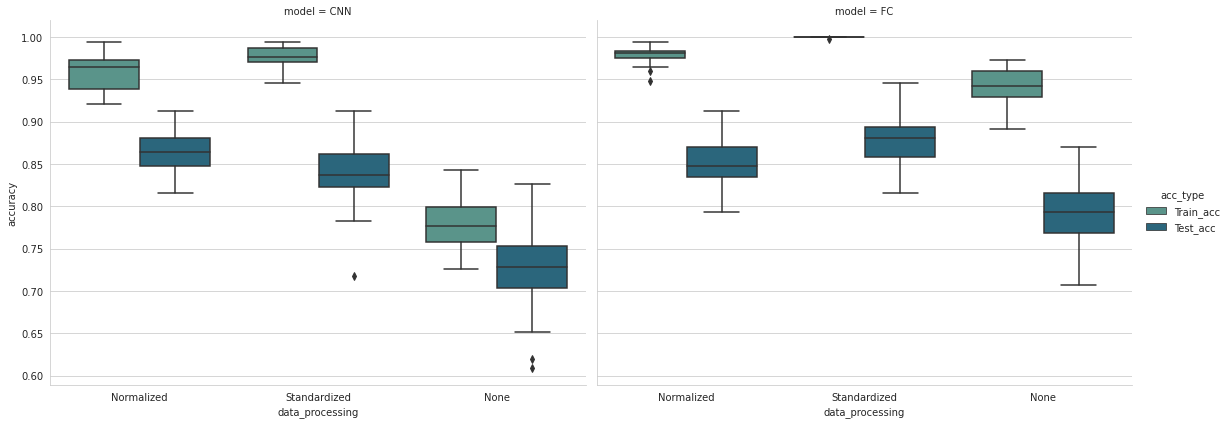

In [50]:
sns.set_style('whitegrid')
sns.catplot(data = acc_data , y='accuracy' , x = 'data_processing' ,
            hue= 'acc_type' , col = 'model' , kind='box' ,
            palette = 'crest' , height=6 , aspect=8/6
            )
plt.savefig('/content/drive/MyDrive/thesis_data/acc_result_plot.jpg')
plt.show()

In [75]:
acc_data_fc = pd.concat([acc_norm_fc , acc_std_fc , acc_og_fc]).reset_index(drop=True)

In [ ]:
acc_data_cnn = pd.concat([acc_norm_cnn , acc_std_cnn , acc_og_cnn]).reset_index(drop=True)

In [66]:
display(acc_data_cnn)

,data_processing,model,train_acc,test_acc
0,Normalized,CNN,0.972826,0.880435
1,Normalized,CNN,0.921196,0.891304
2,Normalized,CNN,0.959239,0.847826
3,Normalized,CNN,0.967391,0.913043
4,Normalized,CNN,0.945652,0.880435
...,...,...,...,...
91,None,CNN,0.967391,0.880435
92,None,CNN,0.959239,0.836957
93,None,CNN,0.980978,0.793478
94,None,CNN,0.948370,0.847826


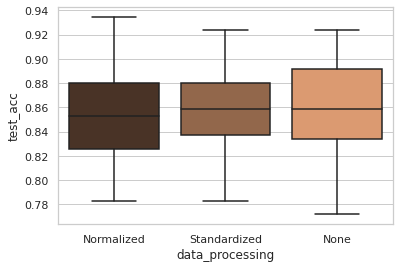

In [70]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data= acc_data_cnn , y='test_acc' , x='data_processing' , palette='copper' , dodge=True)
#ax = sns.swarmplot(data= acc_data , y='acc' , x='model' , hue='type' , palette='copper' , dodge=False , color=".25")
plt.show()

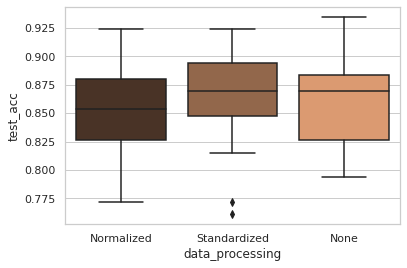

In [79]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data= acc_data_fc , y='test_acc' , x='data_processing' , palette='copper' , dodge=True)
#ax = sns.swarmplot(data= acc_data , y='acc' , x='model' , hue='type' , palette='copper' , dodge=False , color=".25")
plt.show()